# Data wrangling
This notebooks is used to import and clean the datasets

In [6]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'
KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import datetime as dt
import scipy.stats as stats


# from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *
from difflib import SequenceMatcher
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [84]:
def compute_men_women_ratio(x):
    genders = x['a_gender']
    nb_actors = x['a_name'].count()
    nb_male = genders[genders == 'M'].count()
    nb_female = genders[genders == 'F'].count()
    nb_nan_gender = genders.isna().sum()

    nb_known_gender = nb_known_gender=nb_male+nb_female
    m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
    m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
    f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
    nan_ratio = nb_nan_gender / x.shape[0]

    return pd.Series(index=['nb_actors', 'nb_men', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])



In [85]:
def filter_with_countries(df, target_countries, mode):
    """
        TODO fill it
    """
    # TODO drop na on every columns ?
    if mode == 'all':
        return df[df["countries"].apply(lambda x: all(country in x for country in target_countries))]
    elif mode == 'any':
        return df[df["countries"].apply(lambda x: any(country in x for country in target_countries))]
    elif mode == 'only':
        return df[df["countries"].apply(lambda x: set(x) == set(target_countries))]
    else:
        raise ValueError('mode must be one of [all, any, only]')

In [91]:
def add_movies_stats(characters_movies_df, movies):
    movies_res = movies.copy()
    movies_res = add_gender_stats(characters_movies_df, movies_res)
    movies_res = add_age_height_weight_stats(characters_movies_df, movies_res)
    movies_res = add_ethnicity_stats(characters_movies_df, movies_res)

    return movies_res

# Characters

In [9]:
# load characters
characters = load_characters(CHARACTERS_FILE)
print(characters.shape)
characters.head()

(450669, 10)


,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


In [10]:
# generate profiling report
# profile_characters = ProfileReport(characters, title='Characters report')
# profile_characters.to_file(REPORT_FOLDER + "character_report_0.html")

# Ethnicities

In [11]:
# load ethnicities
# lines with more than 1 value (to run the script, only the first value has been kept)): 
# /m/03ttfc	Spaniards	4	1
# /m/04y8_bm	Multiracial American	2	3	4	5
# /m/017sq0	Eurasian	3	1
# /m/04zjjt	history of the Jews in India	1	3
# /m/027vy0s	White Latin American	1	4
# /m/01kb9y	multiracial people	2	3	4	5
# /m/04fh1b	Blasians	2	3
# /m/03hjx6f	Black Hispanic and Latino Americans	2	3

# clusters:
ethnicity_clusters = {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Latino', 5: 'Native / Indigenous people'}

ethnicities = load_ethnicities(ETHNICITY_FILE, ethnicity_clusters)
ethnicities.head()

,freebase_ethnicity_id,ethnicity_name,cluster_id,ethnicity_cluster_name
0,/m/0x67,African Americans,2,Black
1,/m/064b9n,Omaha people,5,Native / Indigenous people
2,/m/041rx,Jewish people,1,White
3,/m/033tf_,Irish Americans,1,White
4,/m/04gfy7,Indian Americans,3,Asian


In [12]:
# add characters ethnicities
characters = add_characters_ethnicities(characters, ethnicities)
characters.head()

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_name,a_age_at_release,a_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,Black
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,NaN


# Movies

In [13]:
# load movies
movies = load_movies(MOVIES_FILE)

# clean features    
movies = clean_unknowns(movies)
movies = clean_jsons(movies)

print(movies.shape)
movies.head()

(81741, 9)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


In [14]:
# generate profiling report
# profile_movies = ProfileReport(movies, title='Movies report')
# profile_movies.to_file(REPORT_FOLDER + "movies_report_0.html")

In [15]:
# number of nan box office values
nb_nan_movies = movies['box_office_revenue'].isna().sum()
print('Number of known box office values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan box office values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known box office values: 8401 (10.28%)
Number of nan box office values: 73340 (89.72%)


# kaggle movies

In [16]:
# import kaggle dataset
def load_kaggle(KAGGLE_file, columns=['original_title', 'revenue', 'budget', 'vote_average', 'vote_count', 'release_date']):
    kaggle = pd.read_csv(KAGGLE_file, usecols=columns)

    # remove wrongly formatted rows (only 3)
    kaggle = kaggle.drop(kaggle[kaggle['budget'].str.contains('.jpg')].index)
    kaggle['release_date'] = pd.to_datetime(kaggle['release_date'], format='%Y-%m-%d', errors='coerce')

    # convert numerical columns to float
    kaggle['revenue'] = kaggle['revenue'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)
    kaggle['budget'] = kaggle['budget'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)

    return kaggle

kaggle = load_kaggle(KAGGLE_FILE)
print(kaggle.shape)
kaggle.head()

(45463, 6)


,budget,original_title,release_date,revenue,vote_average,vote_count
0,30000000.0,Toy Story,1995-10-30,373554033.0,7.7,5415.0
1,65000000.0,Jumanji,1995-12-15,262797249.0,6.9,2413.0
2,NaN,Grumpier Old Men,1995-12-22,NaN,6.5,92.0
3,16000000.0,Waiting to Exhale,1995-12-22,81452156.0,6.1,34.0
4,NaN,Father of the Bride Part II,1995-02-10,76578911.0,5.7,173.0


In [17]:
#how many budget values of the kaggle dataset are known
kaggle.shape[0] - kaggle['budget'].isna().sum()

8890

# Check whether the kaggle dataset can be trusted
(i.e. contains box office values that we can trust that are the same as the ones in the movies dataset)

In [18]:
df_trust = pd.merge(movies, kaggle, left_on=[movies['name'], movies['release_date'].dt.year], 
                    right_on=[kaggle['original_title'], kaggle['release_date'].dt.year], how='left')
df_trust = df_trust.rename({'release_date_x': 'release_date', 'revenue':'box_office_revenue_kaggle'}, axis=1)
df_trust = df_trust.drop(columns=['original_title', 'key_0', 'key_1', 'release_date_y'])

# select only the rows where the box office revenue is known
df_trust = df_trust[(df_trust['box_office_revenue'].notna()) & (df_trust['box_office_revenue_kaggle'].notna())]

df_trust['box_office_revenue'] = df_trust['box_office_revenue'].astype(float)
df_trust['box_office_revenue_kaggle'] = df_trust['box_office_revenue'].astype(float)

# compare all values
is_same = np.allclose(df_trust['box_office_revenue'].to_numpy(), df_trust['box_office_revenue_kaggle'].to_numpy())

print("Are the values from Kaggle and the values from the movies dataset are the same? {}".format(is_same))

    

Are the values from Kaggle and the values from the movies dataset are the same? True


# Merge kaggle movies and movies

In [19]:
# merge movies and kaggle movies

def merge_movies_kaggle(movies, kaggle):

    df = pd.merge(movies, kaggle, left_on=[movies['name'], movies['release_date'].dt.year], 
        right_on=[kaggle['original_title'], kaggle['release_date'].dt.year], how='left')
    df = df.rename({'release_date_x': 'release_date'}, axis=1)

    # fill the box_office revenue with the kaggle revenue if it's missing
    df['box_office_revenue'] = df['box_office_revenue'].fillna(df['revenue'].copy())
    df = df.drop(columns=['revenue', 'original_title', 'key_0', 'key_1', 'release_date_y'])
    
    return df

merged_movies = merge_movies_kaggle(movies, kaggle)

print(merged_movies.shape)
merged_movies.head()

(81780, 12)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,4.8,299.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],NaN,NaN,NaN


In [20]:
# number of nan box office values
nb_nan_merged_movies = merged_movies['box_office_revenue'].isna().sum()
print('Number of known box office values: {} ({:.2%})'.format(merged_movies.shape[0] - nb_nan_merged_movies, (merged_movies.shape[0] - nb_nan_merged_movies) / merged_movies.shape[0]))
print('Number of nan box office values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

nb_non_nan_movies = movies.shape[0] - nb_nan_movies
nb_non_nan_merged_movies = merged_movies.shape[0] - nb_nan_merged_movies
print('Number of box office values gained with kaggle: {} ({:.2%})'.format(nb_non_nan_merged_movies - nb_non_nan_movies, (nb_non_nan_merged_movies - nb_non_nan_movies) / nb_non_nan_movies))

Number of known box office values: 9475 (11.59%)
Number of nan box office values: 73340 (89.72%)
Number of box office values gained with kaggle: 1074 (12.78%)


In [21]:
merged_movies.shape[0]-merged_movies['budget'].isna().sum()

5338

In [22]:
#drop nan values
merged_movies_budget = merged_movies.dropna(subset=['box_office_revenue','budget'])
merged_movies_budget.head()
merged_movies_budget.shape[0]


4257

In [23]:
#find out what values we have in the counties column
merged_movies_budget['countries'].value_counts()

[United States of America]                            2855
[United States of America, United Kingdom]             208
[United States of America, Germany]                    139
[United States of America, Canada]                     106
[United Kingdom]                                        93
                                                      ... 
[Poland]                                                 1
[United Kingdom, Netherlands]                            1
[Weimar Republic, Germany]                               1
[France, United Kingdom, Morocco]                        1
[United States of America, United Kingdom, Norway]       1
Name: countries, Length: 292, dtype: int64

In [24]:
#add columns with the realtive earnings
#merged_movies_budget['relative_earnings'] = (merged_movies_budget['box_office_revenue']-merged_movies_budget['budget'])/merged_movies_budget['budget']

In [25]:
#create dataframe with only counties == United States of America
merged_movies_budget_USA = merged_movies_budget[merged_movies_budget['countries'] == 'United States of America']
merged_movies_budget_USA.shape()

TypeError: 'tuple' object is not callable

# Merge characters and movies

In [26]:
# merge characters and movies
df = merge_characters_movies(characters, merged_movies)
df.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Desolation Williams,Ice Cube,M,Black,1969-06-15,32.0,1.727
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650


In [27]:
# generate clean df
df1 = generate_clean_df_with_kaggle(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE, KAGGLE_FILE)

#assert(df.equals(df1))
df1.head()

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Akooshay,Wanda De Jesus,F,NaN,1958-08-26,42.0,1.620
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,1974-08-15,27.0,1.780
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Desolation Williams,Ice Cube,M,Black,1969-06-15,32.0,1.727
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Sgt Jericho Butler,Jason Statham,M,NaN,1967-09-12,33.0,1.750
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America],Bashira Kincaid,Clea DuVall,F,NaN,1977-09-25,23.0,1.650


In [28]:
df1[df1['wiki_movie_id'] == 9271903]

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,runtime,genres,languages,countries,char_name,a_name,a_gender,a_ethnicity,a_dob,a_age_at_release,a_height
450834,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Bryce Wilson,M,Black,1972,28.0,NaN
450835,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Thomas Jefferson Byrd,M,Black,1941,58.0,NaN
450836,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],Jermaine Davis,Gary Dourdan,M,White,1966-12-11,33.0,1.88
450837,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Kenya Moore,F,Black,1971-01-24,28.0,1.77
450838,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Rob Hardy,M,Black,NaN,NaN,NaN
450839,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Gretchen Palmer,F,NaN,1961-12-16,38.0,1.67
450840,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Chrystale Wilson,NaN,NaN,NaN,NaN,NaN
450841,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,"[Thriller, Erotic thriller, Romance Film, Psyc...",[English Language],[United States of America],NaN,Soloman K. Smith,NaN,NaN,NaN,NaN,NaN


In [29]:
#group by freebase_movie_id and get the ratio for a_gender =! 'M'
MF_ratio = df1.groupby('wiki_movie_id')['a_gender'].value_counts(normalize=True, dropna=False)
MF_ratio	
MF_ratio.loc[34466855]['M']

KeyError: 34466855

In [30]:
merged_movies_budget


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,4.8,299.0
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,4.8,6.0
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",9000000.0,7.4,73.0
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",6000000.0,7.4,1217.0
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",16000000.0,7.3,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
81688,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,[English Language],[United States of America],"[Thriller, Erotic thriller, Romance Film, Psyc...",200000.0,4.5,1.0
81696,303933,/m/01s7w3,Twister,1996-05-10,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",92000000.0,6.1,966.0
81698,25920477,/m/0b6lqyd,Source Code,2011-03-11,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",32000000.0,7.1,2752.0
81734,54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",39000000.0,6.5,944.0


In [31]:
merged_movies_budget[merged_movies_budget['wiki_movie_id'] == 9271903]

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
81688,9271903,/m/0282j29,Trois,2000-01-01,1160268.0,93.0,[English Language],[United States of America],"[Thriller, Erotic thriller, Romance Film, Psyc...",200000.0,4.5,1.0


In [32]:
df_gender = df1.groupby('wiki_movie_id').apply(compute_men_women_ratio)

df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
df_gender['nb_men'] = df_gender['nb_men'].astype(int)
df_gender['nb_female'] = df_gender['nb_female'].astype(int)
df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)

df_gender 

,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
wiki_movie_id,,,,,,,,
330,4,0,4,0,0.000000,1.000000,0.000000,0.000000
3217,14,10,3,1,0.769231,0.230769,3.333333,0.071429
3333,14,8,6,0,0.571429,0.428571,1.333333,0.000000
3746,15,11,3,1,0.785714,0.214286,3.666667,0.066667
3837,20,18,2,0,0.900000,0.100000,9.000000,0.000000
...,...,...,...,...,...,...,...,...
37373877,7,3,3,1,0.500000,0.500000,1.000000,0.142857
37476824,10,6,4,0,0.600000,0.400000,1.500000,0.000000
37478048,4,3,1,0,0.750000,0.250000,3.000000,0.000000


In [33]:
#do a inner join of df_gender with merged_movies_budget
merged_movies_budget = pd.merge(df_gender, merged_movies_budget, left_on='wiki_movie_id', right_on='wiki_movie_id', how='inner')
merged_movies_budget

,wiki_movie_id,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,3217,14,10,3,1,0.769231,0.230769,3.333333,0.071429,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act...",11000000.0,7.3,852.0
1,3333,14,8,6,0,0.571429,0.428571,1.333333,0.000000,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",100000.0,6.4,109.0
2,3746,15,11,3,1,0.785714,0.214286,3.666667,0.066667,/m/017n9,Blade Runner,1982-06-25,33139618.0,116.0,"[Japanese Language, Cantonese, English Languag...","[United States of America, Hong Kong]","[Thriller, Cyberpunk, Science Fiction, Future ...",28000000.0,7.9,3833.0
3,3837,20,18,2,0,0.900000,0.100000,9.000000,0.000000,/m/018f8,Blazing Saddles,1974-02-07,119500000.0,93.0,"[Yiddish Language, English Language]",[United States of America],"[Western, Satire, Comedy]",2600000.0,7.2,619.0
4,3947,15,10,5,0,0.666667,0.333333,2.000000,0.000000,/m/0191n,Blue Velvet,1986-08-01,8551228.0,120.0,[English Language],[United States of America],"[Thriller, Mystery, Crime Fiction]",6000000.0,7.7,758.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4209,36353137,5,3,2,0,0.600000,0.400000,1.500000,0.000000,/m/0k3m48j,The Canyons,2013-01-01,56825.0,NaN,[Unknown],[Unknown],[Thriller],250000.0,4.1,75.0
4210,36389682,2,0,2,0,0.000000,1.000000,0.000000,0.000000,/m/0k95mpr,The Heat,2013-04-05,158674180.0,NaN,[English Language],[United States of America],[Comedy film],43000000.0,6.5,1595.0
4211,36423358,6,4,2,0,0.666667,0.333333,2.000000,0.000000,/m/0k9390g,Paranoia,2013-09-27,13785015.0,115.0,[English Language],"[France, United States of America]","[Thriller, Drama]",35000000.0,5.6,358.0
4212,36534974,16,9,4,3,0.692308,0.307692,2.250000,0.187500,/m/0kdy118,Noah,2014-03-28,362637473.0,NaN,[English Language],[United States of America],"[Drama, Fantasy]",125000000.0,5.5,2408.0


In [ ]:
#locate the wiki_movie_id in the df_gender dataframe and append the values to the merged_movies_budget dataframe in the column nb_actors
#merged_movies_budget['nb_actors'].loc(wiki_movie_id)

In [ ]:
#doesnt work because we kicked out different movies in both dataframes (replaced by #do a inner join of df_gender with merged_movies_budget)
#merged_movies_budget['M_ratio'] = merged_movies_budget['wiki_movie_id'].apply(lambda x: MF_ratio.loc[x]['M'])
#merged_movies_budget['F_ratio'] = merged_movies_budget['wiki_movie_id'].apply(lambda x: MF_ratio.loc[x]['F'])

In [34]:
type(df1.groupby('freebase_movie_id')['a_gender'])

pandas.core.groupby.generic.SeriesGroupBy

In [35]:
df1.groupby('freebase_movie_id')['a_ethnicity'].value_counts()


freebase_movie_id  a_ethnicity
/m/011_mj          White          1
/m/011wtv          White          6
                   Black          3
/m/011x_4          White          2
/m/011xg5          White          7
                                 ..
/m/0yyts           White          2
/m/0yzbg           White          1
/m/0yzp8           White          2
                   Black          1
/m/0yzvw           White          4
Name: a_ethnicity, Length: 46113, dtype: int64

<AxesSubplot:>

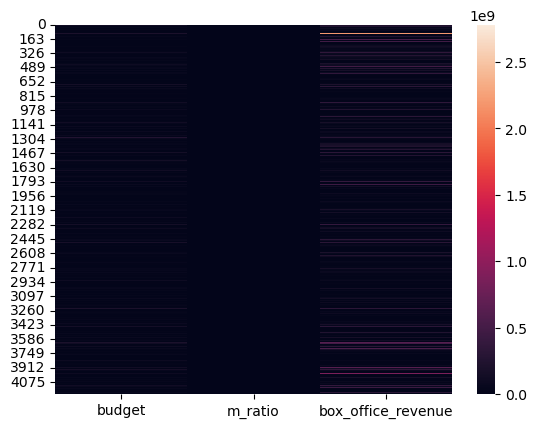

In [ ]:
df2 = merged_movies_budget[['budget', 'm_ratio', 'box_office_revenue']]
sns.heatmap(df2)
#heatmap with on the x axis the budget, gender ratio on the y axis and the color representing the box office revenue
#sns.heatmap(x= merged_movies_budget['budget'], y= merged_movies_budget['m_ratio'], data=merged_movies_budget, cmap='viridis', cbar_kws={'label': 'Box Office Revenue'})
#sns.heatplot(x= merged_movies_budget['budget'], y= merged_movies_budget['m_ratio'], data=merged_movies_budget, kind='hex', color='k', height=10, ratio=4, marginal_kws=dict(bins=15, rug=True), xlim=(0, 10e7), ylim=(0, 1))



In [89]:
#drop entries where the countires do not contain the United States of America (TODO)
#merged_movies_budget_USA = merged_movies_budget['countries'] == ['United States of America']
#merged_movies_budget = filter_with_countries(merged_movies_budget, 'United States of America', mode = 'all')
#merged_movies_budget

KeyError: 'countries'

In [93]:
#append the ethnicity stats to merged_movies_budget
merged_movies_budget = add_characters_ethnicities(merged_movies_budget, df1)
merged_movies_budget


KeyError: 'freebase_ethnicity_id'

In [36]:
#pair movies with similar budget values

#merged_movies_budget['dupeIndex'] = merged_movies_budget.groupby(['occupation', 'gender', 'birthyear']).cumcount()

#add the earnings to the dataframe
merged_movies_budget['earnings'] = merged_movies_budget['box_office_revenue'] - merged_movies_budget['budget']

#sort the dataframe by earnings
merged_movies_budget = merged_movies_budget.sort_values(by=['earnings'], ascending=False)

#get the year of the release date and merge the two dataframes on the year

matched_merged_movies_budget = merged_movies_budget.merge(merged_movies_budget, on= merged_movies_budget['release_date'].dt.year, how='inner')
#matched_merged_movies_budget = merged_movies_budget.merge(merged_movies_budget, on= merged_movies_budget['budget'], how='inner')


#drop entries where the movie is the same
matched_merged_movies_budget = matched_merged_movies_budget[matched_merged_movies_budget['freebase_movie_id_x'] != matched_merged_movies_budget['freebase_movie_id_y']]


#drop entries where the budget is different by more than 50%
matched_merged_movies_budget = matched_merged_movies_budget[abs(matched_merged_movies_budget['budget_x'] - matched_merged_movies_budget['budget_y']) < 0.50*matched_merged_movies_budget['budget_x']]

#drop entries where earnings_x is less than earnings_y
matched_merged_movies_budget = matched_merged_movies_budget[matched_merged_movies_budget['earnings_x'] > matched_merged_movies_budget['earnings_y']]



#add the earnings columns, earnings = box office revenue - budget
# matched_merged_movies_budget['earnings_x']=matched_merged_movies_budget['box_office_revenue_x']-matched_merged_movies_budget['budget_x']
# matched_merged_movies_budget['earnings_y']=matched_merged_movies_budget['box_office_revenue_y']-matched_merged_movies_budget['budget_y']
matched_merged_movies_budget.shape[0]


65014

In [37]:
#compare the similarity of the genres_x and genres_y
matched_merged_movies_budget['genre_similarity'] = matched_merged_movies_budget.apply(lambda x: SequenceMatcher(None, x['genres_x'], x['genres_y']).ratio(), axis=1)
matched_merged_movies_budget

#drop entries where the genre similarity is less than 0.4
matched_merged_movies_budget = matched_merged_movies_budget[matched_merged_movies_budget['genre_similarity'] > 0.4]
matched_merged_movies_budget.shape[0]


6103

In [38]:
#t test for f_ratio_x and f_ratio_y
ttest_ind(matched_merged_movies_budget['f_ratio_x'], matched_merged_movies_budget['f_ratio_y'])

Ttest_indResult(statistic=2.99382928272524, pvalue=0.0027605203981959634)

In [39]:
(matched_merged_movies_budget['f_ratio_x']-matched_merged_movies_budget['f_ratio_y']).mean()

0.008602332483948157

In [40]:
#making sure the earnings_x is always greater than earnings_y
((matched_merged_movies_budget['earnings_x']-matched_merged_movies_budget['earnings_y'])>0).value_counts()


True    6103
dtype: int64

In [41]:
#check for how many entries the list of the countries includes united states of america
matched_merged_movies_budget['countries_x'].str.contains('United States of America') == True


2         False
4         False
16        False
18        False
29        False
          ...  
496603    False
496649    False
496674    False
496711    False
496806    False
Name: countries_x, Length: 6103, dtype: bool

Mean diff female ratio word usage winner/loser headline           : mean = +0.009, 95.0% C.I.: [+0.00413, +0.01323]
Mean diff male ratio word usage winner/loser headline             : mean = -0.008, 95.0% C.I.: [-0.01296, -0.00380]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.005, 95.0% C.I.: [-0.00722, -0.00200]


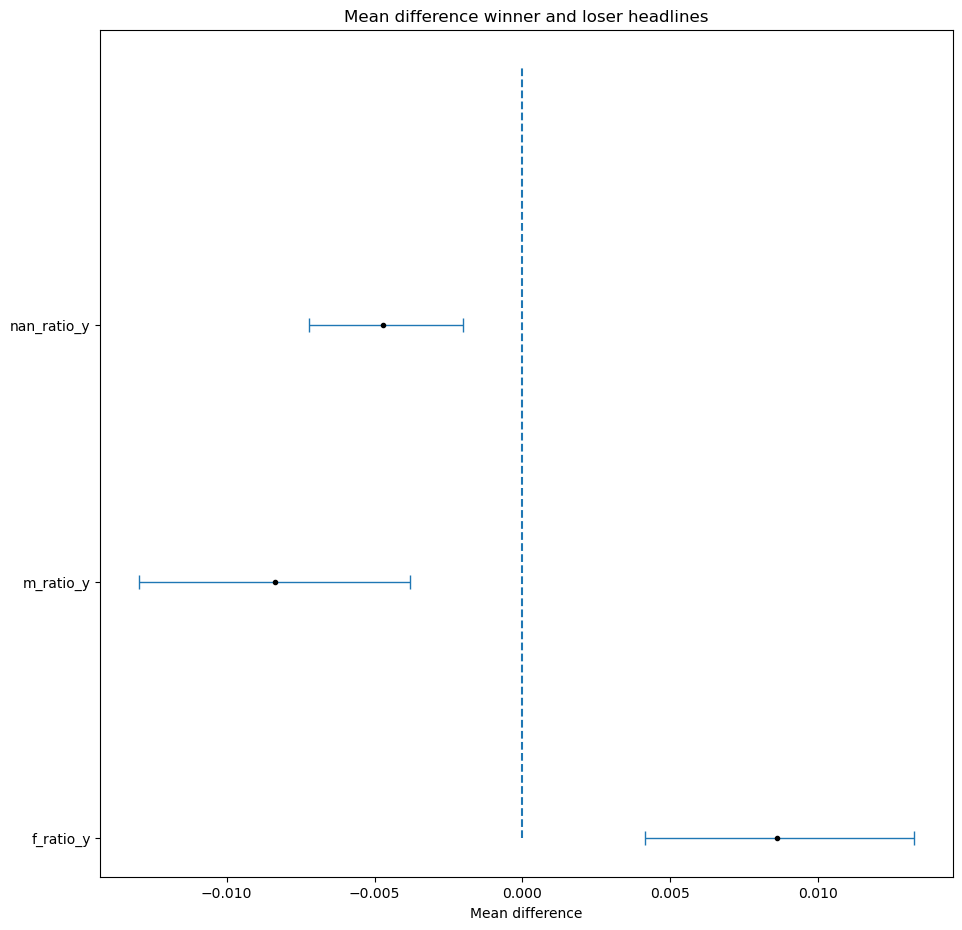

In [42]:
def my_bootstrap(f, df, n_iter= 100, low=0.025, high=0.975):
    """
        Compute the mean difference between the number of words in the winner and the loser headlines
        using bootstrap resampling.
    """
    results = np.zeros(n_iter)

    for i in range(n_iter):
        # sample both winners and losers headlines
        sample = df.sample(n=len(df), replace=True)

        # compute the ratio
        results[i] = f(sample)

    # compute global statistics
    mean = results.mean()
    q_low = np.quantile(results, low)
    q_high = np.quantile(results, high)

    return mean, q_low, q_high

n_iter = 1000

# dict to store mean, CI values and plot them
def print_usage(df, text, bootstrap_values, name="", low=0.025, high=0.975):
    mean, q_low, q_high = bootstrap_values
    ci = high - low
    print("{:66}{}: mean = {:+5.3f}, {:.1%} C.I.: [{:+5.5f}, {:+5.5f}]".format(text, name, mean, ci, q_low, q_high))

def print_usage_diff(df, name="", low=0.025, high=0.975):
    res = {}
    # Ratio
    #print_usage(df, "Mean ratio num words winner/loser headline", my_bootstrap(lambda df: (df['numwords1'] / df['numwords2']).mean(), df, n_iter, low, high))

    # Female words
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['f_ratio_x']-df['f_ratio_y']).mean(), df, n_iter, low, high)
    res['f_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff female ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    #Male ratio
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['m_ratio_x']-df['m_ratio_y']).mean(), df, n_iter, low, high)
    res['m_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff male ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    #Nan ratio
    mean_pos, q_low_pos, q_high_pos = my_bootstrap(lambda df: (df['nan_ratio_x']-df['nan_ratio_y']).mean(), df, n_iter, low, high)
    res['nan_ratio_y'] = (mean_pos, q_low_pos, q_high_pos)
    print_usage(df, "Mean diff nan ratio word usage winner/loser headline", (mean_pos, q_low_pos, q_high_pos))

    # # Negative words
    # mean_neg, q_low_neg, q_high_neg = my_bootstrap(lambda df: (df['negative1'] - df['negative2']).mean(), df, n_iter, low, high)
    # res['negative'] = (mean_neg, q_low_neg, q_high_neg)
    # print_usage(df, "Mean diff negative word usage winner/loser headline", (mean_neg, q_low_neg, q_high_neg))
    
    # # For pronouns difference : compute the difference column-by-column, then sum all differences
    # for pronoun in list(feature_wordsets.keys()): 
    #     mean, q_low, q_high = my_bootstrap(lambda df: (df[pronoun + '1'] - df[pronoun + '2']).mean(), df, n_iter, low, high)
    #     print_usage(df, "Mean diff {:22} word usage winner/loser headline".format(pronoun), (mean, q_low, q_high))
    #     res[pronoun] = (mean, q_low, q_high)
    # res = res.items()
    return res

def plot_errorbars(res, title, xlabel):
    # Plot means and CI for differences
    terms = np.array([x for x in res.keys()])
    means = np.array([x[0] for x in res.values()])
    ci_low = np.array([x[1] for x in res.values()])
    ci_high = np.array([x[2] for x in res.values()])

    plt.figure(figsize=(11, 11))
    plt.errorbar(means, np.array(range(len(means))), xerr=(means-ci_low, ci_high-means), linewidth = 1,
                linestyle = 'none',marker = 'o',markersize= 3,
                markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

    plt.vlines(0,0, len(means), linestyle = '--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.yticks(range(len(terms)),terms)
    plt.show()

res = print_usage_diff(matched_merged_movies_budget)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = -0.152, 95.0% C.I.: [-0.27885, -0.03199]
Mean diff male ratio word usage winner/loser headline             : mean = +0.149, 95.0% C.I.: [+0.03080, +0.27908]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.005, 95.0% C.I.: [-0.03051, +0.02082]


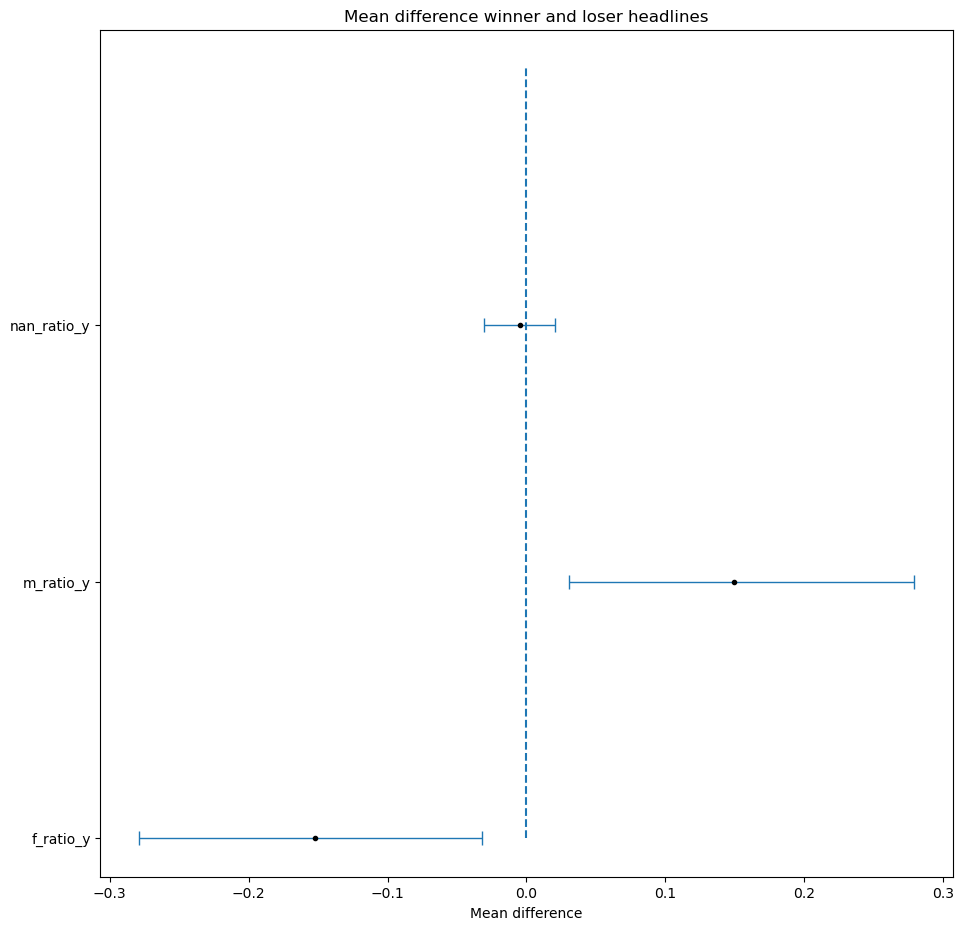

In [69]:
matched_merged_movies_budget_19 = matched_merged_movies_budget[matched_merged_movies_budget['release_date_x'].dt.year < 1950] 
res = print_usage_diff(matched_merged_movies_budget_19)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = +0.005, 95.0% C.I.: [-0.00082, +0.01010]
Mean diff male ratio word usage winner/loser headline             : mean = -0.004, 95.0% C.I.: [-0.01000, +0.00090]
Mean diff nan ratio word usage winner/loser headline              : mean = -0.007, 95.0% C.I.: [-0.01056, -0.00399]


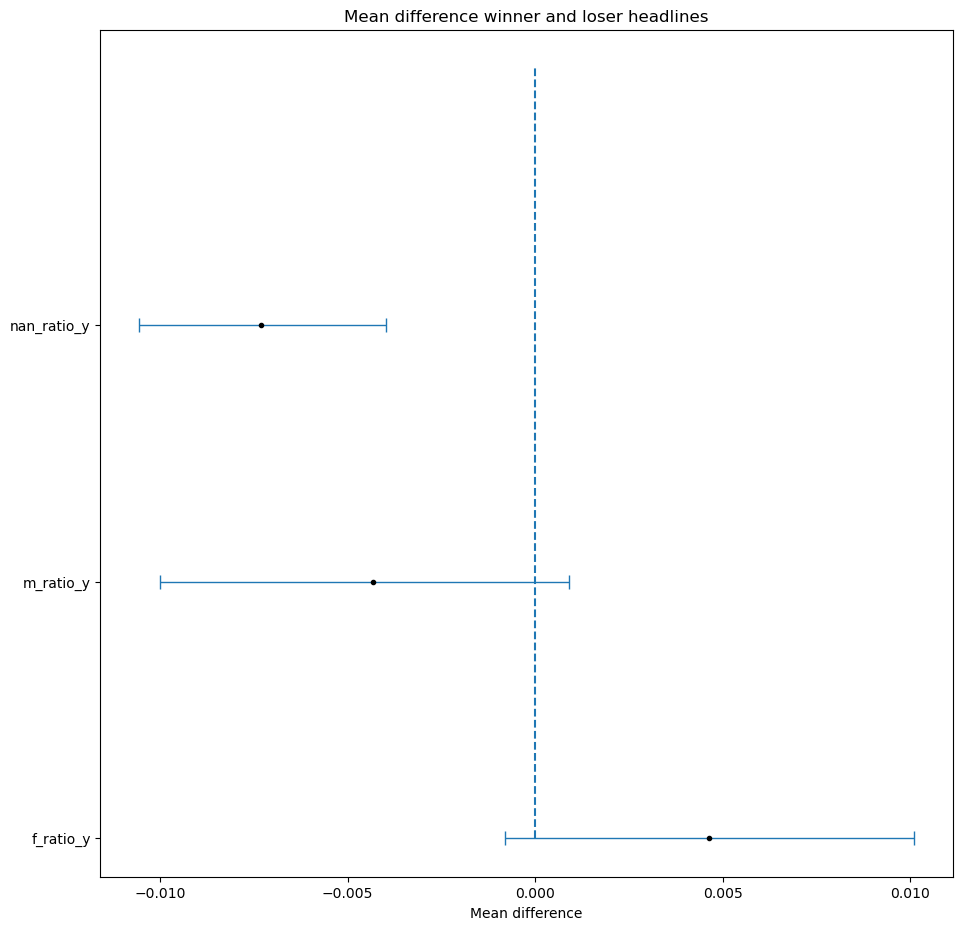

In [80]:
# only keep movies between 1950 and 2010
matched_merged_movies_budget_19_20 = matched_merged_movies_budget[matched_merged_movies_budget['release_date_x'].dt.year < 2010]
matched_merged_movies_budget_19_20 = matched_merged_movies_budget_19_20[matched_merged_movies_budget_19_20['release_date_x'].dt.year > 1949]
res = print_usage_diff(matched_merged_movies_budget_19_20)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

Mean diff female ratio word usage winner/loser headline           : mean = +0.023, 95.0% C.I.: [+0.01256, +0.03182]
Mean diff male ratio word usage winner/loser headline             : mean = -0.022, 95.0% C.I.: [-0.03167, -0.01231]
Mean diff nan ratio word usage winner/loser headline              : mean = +0.003, 95.0% C.I.: [-0.00129, +0.00699]


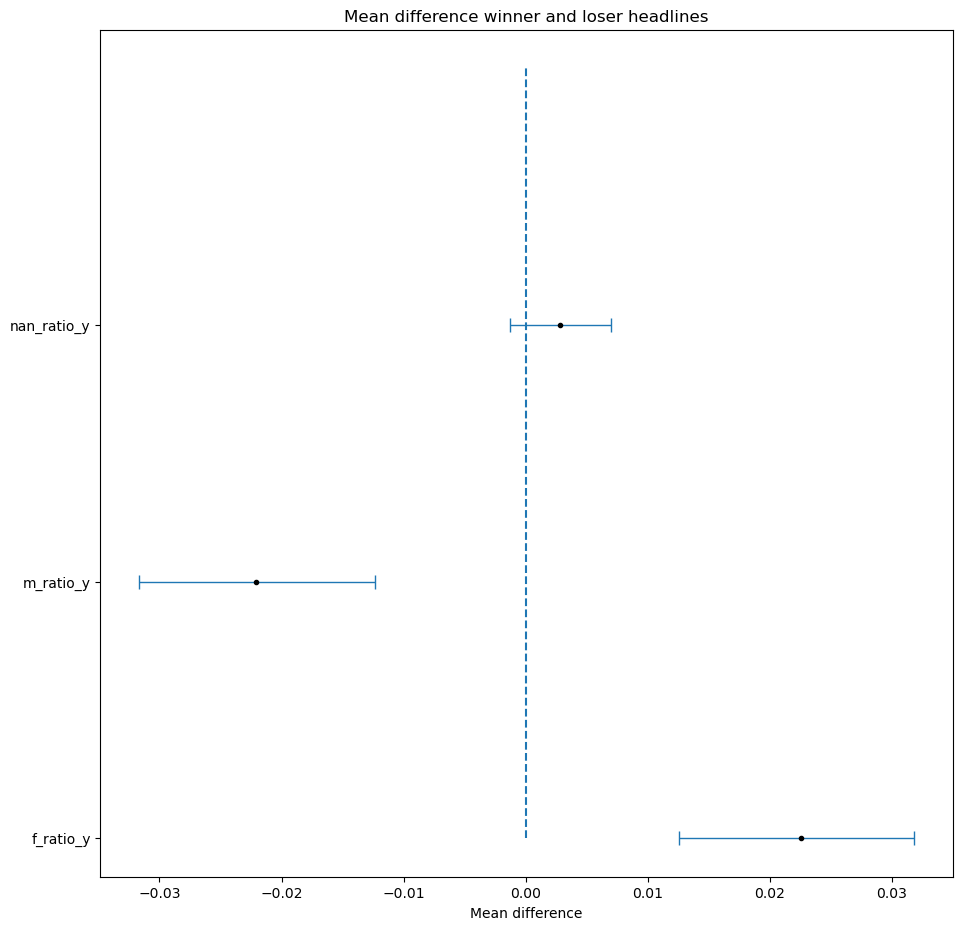

In [70]:
matched_merged_movies_budget_20 = matched_merged_movies_budget[matched_merged_movies_budget['release_date_x'].dt.year > 2009] 
res = print_usage_diff(matched_merged_movies_budget_20)
plot_errorbars(res, "Mean difference winner and loser headlines", "Mean difference")

<AxesSubplot:xlabel='release_date_x'>

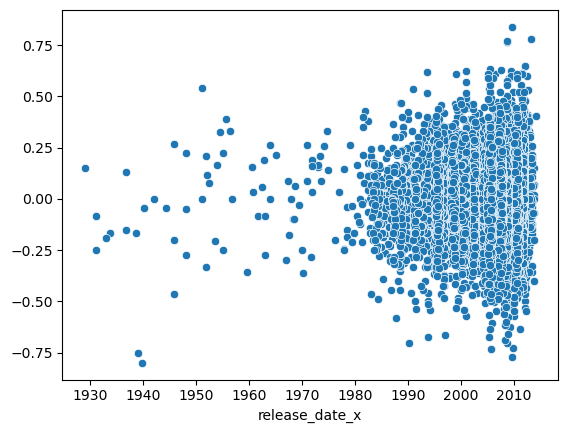

In [45]:
 #scatterplot of the f_ratio_x and the f_ratio_y over the release date
sns.scatterplot(x=matched_merged_movies_budget['release_date_x'], y=matched_merged_movies_budget['f_ratio_x']-matched_merged_movies_budget['f_ratio_y'], data=matched_merged_movies_budget)

In [49]:
#goup data by the release date year and compute the mean of the f_ratio_x and the f_ratio_y
average_per_year = matched_merged_movies_budget.groupby(matched_merged_movies_budget['release_date_x'].dt.year).mean()
average_per_year

,key_0,wiki_movie_id_x,nb_actors_x,nb_men_x,nb_female_x,nb_nan_gender_x,m_ratio_x,f_ratio_x,M_F_ratio_x,nan_ratio_x,...,f_ratio_y,M_F_ratio_y,nan_ratio_y,box_office_revenue_y,runtime_y,budget_y,vote_average_y,vote_count_y,earnings_y,genre_similarity
release_date_x,,,,,,,,,,,,,,,,,,,,,
1928,1928.0,2.458766e+07,10.000000,6.000000,4.000000,0.000000,0.600000,0.400000,1.500000,0.000000,...,0.250000,3.000000,0.000000,5.960000e+05,78.000000,2.900000e+05,7.700000,3.000000,3.060000e+05,0.600000
1931,1931.0,7.348800e+04,12.000000,9.000000,3.000000,0.000000,0.750000,0.250000,3.000000,0.000000,...,0.416667,1.500000,0.000000,1.012189e+06,89.500000,3.550000e+05,7.200000,254.000000,6.571890e+05,0.583333
1933,1933.0,2.155730e+06,9.500000,7.000000,2.500000,0.000000,0.762821,0.237179,3.625000,0.000000,...,0.416667,1.500000,0.000000,1.650000e+06,76.500000,2.300000e+05,3.950000,16.500000,1.420000e+06,0.522727
1936,1936.0,3.561912e+06,9.000000,6.500000,2.000000,0.500000,0.742424,0.257576,3.250000,0.041667,...,0.266667,3.000000,0.000000,1.647500e+06,113.000000,9.915000e+05,4.550000,5.000000,6.560000e+05,0.480952
1938,1938.0,1.838833e+07,15.000000,10.000000,5.000000,0.000000,0.666667,0.333333,2.000000,0.000000,...,0.500000,1.000000,0.000000,3.600000e+06,106.000000,2.000000e+06,4.800000,6.000000,1.600000e+06,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,2010.0,2.291807e+07,17.031477,10.658596,5.769976,0.644068,0.660763,0.339237,2.960541,0.038774,...,0.341801,2.972827,0.040537,6.419608e+07,106.036320,3.920064e+07,6.102906,602.285714,2.499544e+07,0.560877
2011,2011.0,2.749338e+07,16.269710,9.817427,6.360996,0.141079,0.599393,0.400607,1.965758,0.009061,...,0.367862,2.282702,0.003825,4.766899e+07,107.796634,3.271395e+07,5.961411,564.593361,1.495503e+07,0.577929
2012,2012.0,3.063870e+07,14.488372,9.305233,4.930233,0.456395,0.658718,0.341282,2.419676,0.022547,...,0.307501,2.448800,0.017524,6.482986e+07,106.619926,4.217651e+07,5.993895,933.250000,2.265335e+07,0.606989


In [56]:
average_per_year['f_ratio_difference'] = average_per_year['f_ratio_x']-average_per_year['f_ratio_y']

<AxesSubplot:xlabel='release_date_x', ylabel='f_ratio_difference'>

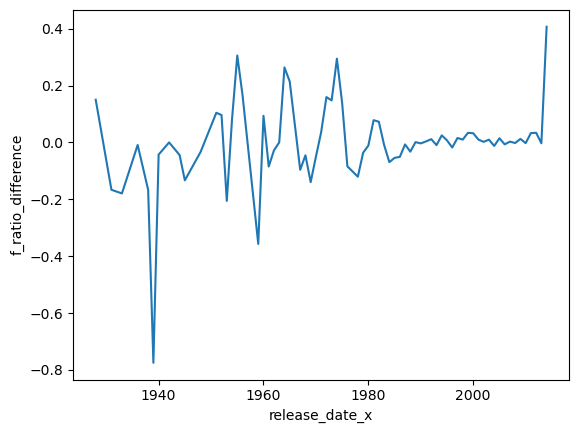

In [57]:
sns.lineplot(data=average_per_year, x='release_date_x', y='f_ratio_difference')

<AxesSubplot:xlabel='release_date_y', ylabel='f_ratio_y'>

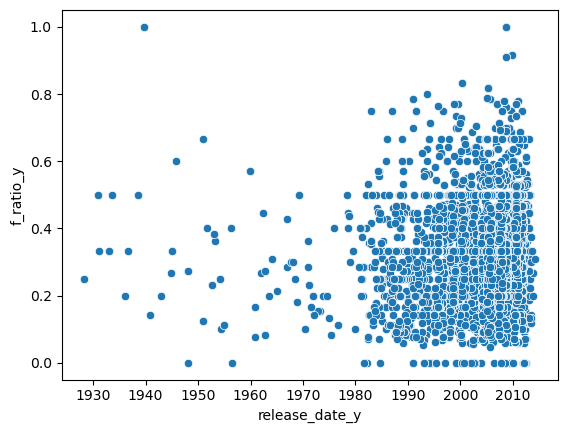

In [81]:
 #scatterplot of the f_ratio_x and the f_ratio_y over the release date
sns.scatterplot(x=matched_merged_movies_budget['release_date_y'], y=matched_merged_movies_budget['f_ratio_y'], data=matched_merged_movies_budget)

In [ ]:
#trying out the SequenceMatcher ()
SequenceMatcher(None, matched_merged_movies_budget['genres_x'], matched_merged_movies_budget['genres_y'])

TypeError: unhashable type: 'list'

In [ ]:
#count the ratio of Nan values in the box_office column
df1.groupby('freebase_movie_id')['box_office_revenue'].isna().sum()/df1.shape[0]



AttributeError: 'SeriesGroupBy' object has no attribute 'isna'